# Оценка длительностей и количества раундов инвентаризации

В этом эксперименте найдем оценки длительностей раундов инвентаризации и их 
числа за время нахождения метки в области действия счиытвателя.

## Настройка ноутбука

In [108]:
# Если что-то меняется в коде, мы хотим это сразу видеть здесь
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [109]:
import os

import locale

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import patches

from tabulate import tabulate
from tqdm.notebook import tqdm

from itertools import product
from collections import namedtuple
from copy import deepcopy
import time
import numpy as np
import pandas as pd
from typing import Sequence, Tuple, Optional, Union, Iterable

# Подключаем локальные пакеты
import pyons
from pyons.models.rfid import protocol as gen2
from pyons.models.rfid.protocol import TagFrame, ReaderFrame, TagEncoding, \
    DR, InventoryFlag as Flag

In [110]:
# Настраиваем matplotlib
%matplotlib inline
CMAP_NAME = 'inferno'  # Цветовая схема для графиков

matplotlib.rcParams.update({
    'image.cmap': CMAP_NAME,
    'axes.formatter.use_locale': True,
    'font.size': 16,
    'font.family': 'sans-serif',
    
    # Шрифт PT Serif Caption можно установить с Google Fonts.
    # После установки шрифта нужно удалить кэш matplitlib,
    # на Ubuntu: ~/.cache/matplotlib 
    'font.sans-serif': ['PT Serif Caption',],
})

locale.setlocale(locale.LC_ALL, 'ru_RU.UTF-8')

'ru_RU.UTF-8'

Введем вспомогательные функции для сохранения изображений и конвертации единиц.

In [111]:
IMAGE_BASE_DIR = "images"  # Здесь будут храниться все построенные изображения


def get_color(x):
    """
    Получить цвет из текущей карты.
    """
    return cm.get_cmap(CMAP_NAME)(x)


def savefig(out: Union[str, Sequence[str]] = ()):
    if out:
        if isinstance(out, str):
            out = (out,)
        for file_name in out:
            file_path = os.path.join(IMAGE_BASE_DIR, file_name)
            plt.savefig(file_path, bbox_inches="tight")

            
def kmph2mps(x: float) -> float:
    """Перевести км/ч в м/с"""
    return x * 5 / 18


def str_dr(dr: DR) -> str:
    return "64/3" if dr == DR.DR_643 else "8"


def random_hex_string(bs: int) -> str:
    return "".join([f"{np.random.randint(0, 256):02X}" for _ in range(bs)])

## Параметры окружения

Зададим общие параметры, которые будут использоваться в расчетах по-умолчанию.

In [112]:
TARI_US = [6.25, 12.5, 18.75, 25]
M = [gen2.TagEncoding.FM0, gen2.TagEncoding.M2, 
     gen2.TagEncoding.M4, gen2.TagEncoding.M8]
DRS = [gen2.DR.DR_8, gen2.DR.DR_643]
L = 5             # длина области, где есть связь между считывателем и меткой
V = 60            # скорость автомобиля, км/ч
Q = 4             # по-умолчанию, будем исходить из этого значения параметра Q
RTCAL_MUL = 2.25  # во сколько раз RTcal больше Tari
TRCAL_MUL = 1.95  # во сколько раз TRcal больше RTcal
EPC_SIZE = 12     # длина EPCID в байтах
TID_SIZE = 8      # длина TID в байтах

EPC = random_hex_string(EPC_SIZE)
TID = random_hex_string(TID_SIZE)

print("I will use these constants:")
print(f"- EPC: {EPC} ({EPC_SIZE} bytes)")
print(f"- TID: {TID} ({TID_SIZE} bytes)")

I will use these constants:
- EPC: D7F29ACC532A88335351F962 (12 bytes)
- TID: BCD0F888DD512FC8 (8 bytes)


## Расчет длительностей команд и ответов

Для начала определим, как будут меняться длительность команд считывателя и ответов метки в зависимости от настроек протокола.

Будем рассматривать длительности сообщений:

- команд `Query`, `QueryRep`, `Ack`, `Req_RN`, `Read`
- ответов `RN16`, `EPC+PC+CRC`, `Handle`, `Data`

Зависимости будем проверять от:

- `DR` (и команды, и ответы)
- `Tari` (и команды, и ответы)
- `TRExt` (только ответы)
- `M` (ответы)

Длительности символов `data-1`, `RTcal` и `TRcal` определяются через множители 
`Tari`. Согласно стандарту (c. 29):

- `2.5 Tari <= RTcal <= 3.0 Tari`
- `1.1 RTcal <= TRcal <= 3.0 RTcal`

При расчете будем ориентироваться на средние значения коэффициентов, то есть 
будем полагать, что:

- `RTcal = 2.25 Tari`
- `TRcal = 1.95 RTcal`

Длительность `RTcal` равна суммарной длительности `data-0 = Tari` и `data-1`.

Кроме длительностей команд и ответов вычислим величину `BLF = DR / TRcal` и 
скорость в канале от метки к считывателю, равную `BLF / M`.

> Для удобства, все длительности будем хранить в **микросекундах**, BLF - 
в **КГц**, а bitrate - в **кбит/c**.

In [113]:
def build_messages_df():
    rows = []
    for tari_us, m, dr, trext in product(TARI_US, M, DRS, (False, True)):
        tari = tari_us * 1e-6
        rtcal = RTCAL_MUL * tari
        trcal = TRCAL_MUL * rtcal
        blf = dr.ratio / trcal
        bitrate = blf / m.value
        
        # Строим команды
        # --------------
        preamble = gen2.ReaderFrame.Preamble(tari, rtcal, trcal)
        sync = gen2.ReaderFrame.Sync(tari, rtcal)
        
        query = gen2.Query(dr=dr, m=m, trext=trext, sel=gen2.Sel.SL_ALL, 
                           session=gen2.Session.S0, target=gen2.InventoryFlag.A, 
                           q=4, crc5=0x15)
        query_rep = gen2.QueryRep(session=gen2.Session.S0)
        ack = gen2.Ack(0x5555)
        req_rn = gen2.ReqRn(0x5555, 0x5555)
        read = gen2.Read(gen2.Bank.TID, 0, 4, rn=0x5555, crc16=0x5555)
        
        # Строим ответы
        # -------------
        rn16 = gen2.Rn16Reply(0x5555)
        epc_pc = gen2.AckReply(EPC)
        handle = gen2.ReqRnReply(0)
        data = gen2.ReadReply([0xABAB] * (TID_SIZE//2), 0, 0)
        
        rows.append({
            'Tari': tari_us,     
            'RTcal': rtcal * 1_000_000,
            'TRcal': trcal * 1_000_000,
            'M': m,
            'DR': dr,
            'BLF': blf / 1_000,
            'TRext': trext,
            'Bitrate': bitrate / 1_000,
            'Query': ReaderFrame(preamble, query).duration * 1_000_000,
            'QueryRep': ReaderFrame(sync, query_rep).duration * 1_000_000,
            'Ack': ReaderFrame(sync, ack).duration * 1_000_000,
            'Req_RN': ReaderFrame(sync, req_rn).duration * 1_000_000,
            'Read': ReaderFrame(sync, read).duration * 1_000_000,
            'RN16': TagFrame(m, trext, blf, rn16).duration * 1_000_000,
            'EPC+PC+CRC': TagFrame(m, trext, blf, epc_pc).duration * 1_000_000,
            'Handle': TagFrame(m, trext, blf, handle).duration * 1_000_000,
            'Data': TagFrame(m, trext, blf, data).duration * 1_000_000,
        })
    df = pd.DataFrame(rows)
    return df

DF = build_messages_df()
DF

,Tari,RTcal,TRcal,M,DR,BLF,TRext,Bitrate,Query,QueryRep,Ack,Req_RN,Read,RN16,EPC+PC+CRC,Handle,Data
0,6.25,14.0625,27.421875,TagEncoding.FM0,DR.DR_8,291.737892,False,291.737892,205.546875,57.8125,159.375,312.5,428.125,78.837891,462.744141,133.681641,356.484375
1,6.25,14.0625,27.421875,TagEncoding.FM0,DR.DR_8,291.737892,True,291.737892,207.109375,57.8125,159.375,312.5,428.125,119.970703,503.876953,174.814453,397.617187
2,6.25,14.0625,27.421875,TagEncoding.FM0,DR.DR_643,777.967711,False,777.967711,207.109375,57.8125,159.375,312.5,428.125,29.564209,173.529053,50.130615,133.681641
3,6.25,14.0625,27.421875,TagEncoding.FM0,DR.DR_643,777.967711,True,777.967711,208.671875,57.8125,159.375,312.5,428.125,44.989014,188.953857,65.555420,149.106445
4,6.25,14.0625,27.421875,TagEncoding.M2,DR.DR_8,291.737892,False,145.868946,207.109375,57.8125,159.375,312.5,428.125,185.097656,952.910156,294.785156,740.390625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,25.00,56.2500,109.687500,TagEncoding.M4,DR.DR_643,194.491928,True,48.622982,803.437500,193.7500,600.000,1212.5,1675.000,802.089844,3105.527344,1131.152344,2467.968750
60,25.00,56.2500,109.687500,TagEncoding.M8,DR.DR_8,72.934473,False,9.116809,797.187500,193.7500,600.000,1212.5,1675.000,2961.562500,15246.562500,4716.562500,11846.250000
61,25.00,56.2500,109.687500,TagEncoding.M8,DR.DR_8,72.934473,True,9.116809,803.437500,193.7500,600.000,1212.5,1675.000,4277.812500,16562.812500,6032.812500,13162.500000
62,25.00,56.2500,109.687500,TagEncoding.M8,DR.DR_643,194.491928,False,24.311491,803.437500,193.7500,600.000,1212.5,1675.000,1110.585938,5717.460938,1768.710937,4442.343750


In [114]:
def set_axes_formatter(*axes, use_x=False, use_y=False):
    """
    У некоторых нормальных шрифтов нет глифов, которые нужны
    в русской локали. Поэтому стараемся избежать ситуации,
    когда эти глифы нужны.
    
    Сейчас обходим глиф-пробел 8239 в формате больших целых.
    """
    def fmt(value, tick_num):
        if isinstance(value, int):
            return f"{value:g}"
        elif isinstance(value, float):
            if int(value) == value:
                return f"{value:g}"
            else:
                return f"{value:n}"
        return str(value)
    
    for axes_ in axes:
        if not (isinstance(axes_, list) or isinstance(axes_, tuple)):
            axes_ = (axes_,)
        for ax in axes_:
            if use_y:
                ax.yaxis.set_major_formatter(plt.FuncFormatter(fmt))
            if use_x:
                ax.xaxis.set_major_formatter(plt.FuncFormatter(fmt))
            

Посмотрим на общий разброс длительностей отдельных команд и ответов.

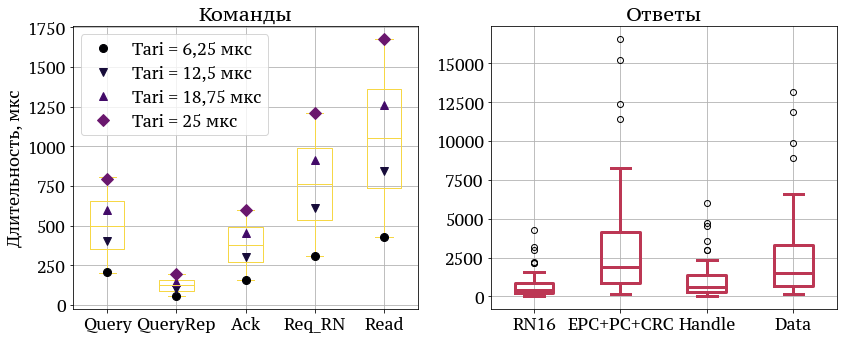

In [115]:
def plot_boxes_for_all_messages(out: Union[str, Sequence[str]] = ()):
    fig, (ax0, ax1) = plt.subplots(figsize=(12, 5), nrows=1, ncols=2)
    
    props_0 = {'linewidth': 1, 'color': get_color(0.9)}
    props_1 = {'linewidth': 3, 'color': get_color(0.5)}
    
    COMMANDS = ['Query', 'QueryRep', 'Ack', 'Req_RN', 'Read']
    RESPONSES = ['RN16', 'EPC+PC+CRC', 'Handle', 'Data']
    
    DF.boxplot(COMMANDS, ax=ax0, 
               boxprops=props_0, whiskerprops=props_0, capprops=props_0, 
               meanprops=props_0, medianprops=props_0, 
               positions=range(len(COMMANDS)))

    DF.boxplot(RESPONSES, ax=ax1, 
               boxprops=props_1, whiskerprops=props_1, capprops=props_1, 
               meanprops=props_1, medianprops=props_1)
    
    df = (DF[[*COMMANDS, "Tari"]]
          .groupby("Tari", as_index=False)
          .mean()
          .melt(id_vars=['Tari'], var_name="CMD", value_name="Duration"))
    
    markers = ["o", "v", "^", "D"]
    
    for i, tari in enumerate(TARI_US):
        df1 = df[df.Tari == tari]
        ax0.plot(range(len(COMMANDS)), df1["Duration"], 
                 color=get_color(i/10), linestyle='', marker=markers[i],
                 markersize=8, label=f"Tari = {tari:n} мкс")
    
    set_axes_formatter(ax0, ax1, use_y=True)
    ax0.legend()
    ax0.set_ylabel("Длительность, мкс")
    ax0.set_title("Команды")
    ax1.set_title("Ответы")
    
    
    plt.tight_layout()
    savefig(out)

plot_boxes_for_all_messages(out=("ch2_messages_durations.pdf", "ch2_messages_durations.png"))

Можно заметить, что разброс длительностей команд и ответов очень большой. Длительности команд могут различаться в 3-5 раз, а длительности ответов - в 10 и больше раз.


Рассмотрим внимательнее, как зависят длительности ответов от тех или иных параметров.

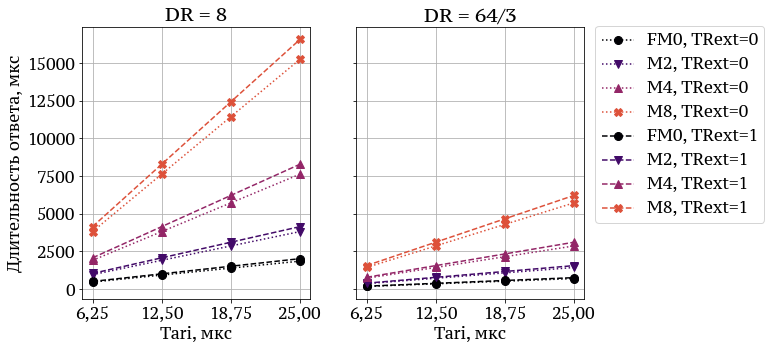

In [137]:
def plot_t2r_props(out: Union[str, Sequence[str]] = ()):
    fig, (ax0, ax1) = plt.subplots(figsize=(9, 5), ncols=2, sharey=True)
    
    markers = ["o", "v", "^", "X"]
    linestyles = [':', '--']
    
    for i, trext in enumerate([False, True]):
        df = DF[DF.TRext == trext][["Tari", "M", "DR", "EPC+PC+CRC", "BLF"]]
        df0 = df[df.DR == DR.DR_8]
        df1 = df[df.DR == DR.DR_643]
        ls = linestyles[i]

        for j, m in enumerate(M):
            
            y0 = [df0[(df0.Tari == t) & (df0.M == m)]['EPC+PC+CRC'] 
                  for t in TARI_US]
            
            y1 = [df1[(df1.Tari == t) & (df1.M == m)]['EPC+PC+CRC'] 
                  for t in TARI_US]
            
            c = get_color(j / len(M) * 0.8)
            marker = markers[j]
            
            label = f"{m.name}, TRext={1 if trext else 0}"
            ax0.plot(TARI_US, y0, linestyle=ls, color=c, 
                     marker=marker, markersize=8, label=label)
            ax1.plot(TARI_US, y1, linestyle=ls, color=c, 
                     marker=marker, markersize=8, label=label)
    
    for ax in (ax0, ax1):
        ax.set_xticks(TARI_US)
        ax.set_xlabel("Tari, мкс")
        ax.grid()
    
    ax0.set_ylabel("Длительность ответа, мкс") 
    ax0.set_title("DR = 8")
    ax1.set_title("DR = 64/3")
        
    set_axes_formatter(ax0, ax1, use_y=True)
    handles, labels = ax0.get_legend_handles_labels()
    fig.legend(handles, labels, loc='center right', 
               bbox_to_anchor=(1.19, 0.61), ncol=1)
    savefig(out)

plot_t2r_props(out=("ch2_response_durations.pdf", "ch2_response_durations.png"))

## Вычисление длительности раунда с одной меткой

В следующих расчетах будем исходить из предположения, что в раунде участвует одна метка.
В общем случае это предположение, конечно, не выполняется, но для системы идентификации
автомобилей оно имеет смысл - из-за геометрии автомобилей и малой длины области чтения
вероятность попадания двух и более меток в зону действия считывателя одновременно мала.

Максимальную длительность раунда будем вычислять по формуле:

$$
\overline{T}_R = t_s + (2^Q - 1) t_e,
$$
где $t_e = T_{\text{QueryRep}} + T_1 + T_3$ - длительность пустого слота, а $t_s$ -
длительность слота с ответом. Если требуется идентифицировать метку только по EPCID,
то $t_s = t_s^{\text{epc}}$:

$$
t_s^{\text{epc}} = T_{\text{Query}} + T_1 + T_{\text{RN16}} + T_2 + 
T_{\text{ACK}} + T_1 + T_{\text{EPCID}} + T_2.
$$

Если же для идентификации используется TID, то $t_s = t_s^{\text{tid}}$:

$$
t_s^{\text{tid}} = t_s^{\text{epc}} + T_{\text{Req_RN}} + T_1 + 
T_{\text{Handle}} + T_2 + T_{\text{Read}} + T_1 + T_{\text{Data}} + T_2.
$$

В действительности длительность раунда вычисляется гораздо сложнее. Если в раунде 
участвуют несколько меток, то будет больше слотов с успешными передачами, а также могут
появиться слоты с коллизиями. Кроме того, из-за BER слоты с ответами меток без коллизий
могут иметь меньшую длительность, если какой-то из ответов не будет доставлен.

> Подробнее зависимости длительностей раундов анализируются в главе, посвященной 
> аналитической модели системы радиочастотной идентификации.

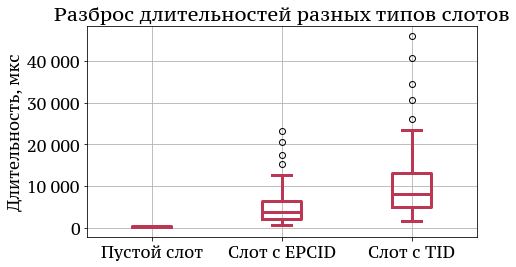

In [117]:
# При вычислении T1 делаем поправку на масштаб: времена в таблице
# записаны в микросекундах, частота BLF - в КГц. Результат вычислений
# мы будем хранить тоже в микросекундах.
DF["T1"] = DF.apply(lambda x: gen2.max_t1(x.RTcal, x.BLF/1_000), axis=1)
DF["T2"] = DF.apply(lambda x: gen2.max_t2(x.BLF/1_000), axis=1)
DF["T3"] = 0

def get_empty_slot(row: pd.DataFrame) -> float:
    return row["QueryRep"] + row["T1"] + row["T3"]

def get_reply_epcid_slot(row: pd.DataFrame) -> float:
    t = row["Query"] + 2 * (row["T1"] + row["T2"]) + \
        row["RN16"] + row["Ack"] + row["EPC+PC+CRC"]
    return t

def get_reply_tid_slot(row: pd.DataFrame) -> float:
    t = get_reply_epcid_slot(row) + 2 * (row["T1"] + row["T2"]) + \
        row["Req_RN"] + row["Handle"] + row["Read"] + row["Data"]
    return t

DF["EmptySlot"] = DF.apply(get_empty_slot, axis=1)
DF["EpcReplySlot"] = DF.apply(get_reply_epcid_slot, axis=1)
DF["TidReplySlot"] = DF.apply(get_reply_tid_slot, axis=1)

# Изобразим длительности слотов. Сохранять рисунок не будем.

def plot_slots():
    fig, ax = plt.subplots(figsize=(7, 4), nrows=1, ncols=1)
    props = {'linewidth': 3, 'color': get_color(0.5)}
    DF.boxplot(["EmptySlot", "EpcReplySlot", "TidReplySlot"], ax=ax,
               boxprops=props, whiskerprops=props, capprops=props, 
               meanprops=props, medianprops=props)
    ax.set_xticklabels(["Пустой слот", "Слот с EPCID", "Слот с TID"])
    ax.set_title("Разброс длительностей разных типов слотов")
    ax.set_ylabel("Длительность, мкс")
    plt.tight_layout()

plot_slots()

In [118]:
def get_max_round(row: pd.DataFrame, q: int, use_tid: bool = False) -> float:
    reply_slot_col = "EpcReplySlot" if not use_tid else "TidReplySlot"
    return row["EmptySlot"] * (2**q - 1) + row[reply_slot_col]

Рассчитаем максимальные длительности раундов для разных Tari и M.

Чтобы немного упростить вывод, не будем рассматривать все возможные комбинации 
`Tari`, `M`, `DR`, а выделим шесть разных наборов:

- `Tari = 6.25, M = 1, DR = 64/3` (самый быстрый)
- `Tari = 6.25, M = 4, DR = 64/3`
- `Tari = 12.5, M = 4, DR = 64/3`
- `Tari = 12.5, M = 4, DR = 8`
- `Tari = 25.0, M = 4, DR = 8`
- `Tari = 25.0, M = 8, DR = 8` (самый медленный)

In [119]:
ROUNDS_TARI_M_DR = [
    [6.25, TagEncoding.FM0, DR.DR_643],
    [6.25, TagEncoding.M4, DR.DR_643],
    [12.5, TagEncoding.M4, DR.DR_643],
    [12.5, TagEncoding.M4, DR.DR_8],
    [25.0, TagEncoding.M4, DR.DR_8],
    [25.0, TagEncoding.M8, DR.DR_8]
]
ROUNDS_MARKERS = ["o", "v", "^", "X", "<", ">"]
ROUNDS_COLORS = [get_color(i / len(ROUNDS_TARI_M_DR) * 0.8)
                 for i in range(len(ROUNDS_TARI_M_DR))]

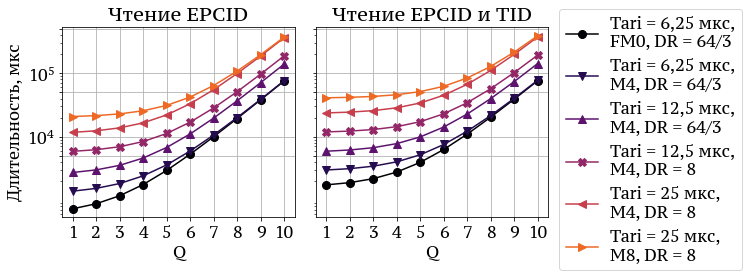

In [129]:
def plot_max_rounds(out: Union[str, Sequence[str]] = ()):
    fig, axes = plt.subplots(figsize=(8, 4), nrows=1, ncols=2, sharey=True)
    ax0, ax1 = axes
    
    ox = list(range(1, 11))
    df = DF[DF.TRext == False]
    
    for i, (tari, m, dr) in enumerate(ROUNDS_TARI_M_DR):    
        df_row = df[(df.Tari == tari) & (df.M == m) & (df.DR == dr)]
        
        oy_epc = [get_max_round(df_row, q, use_tid=False) for q in ox]
        oy_tid = [get_max_round(df_row, q, use_tid=True) for q in ox]

        c = ROUNDS_COLORS[i]
        marker = ROUNDS_MARKERS[i]
        label = f"Tari = {tari:n} мкс,\n{m.name}, DR = {str_dr(dr)}"
        
        ax0.plot(ox, oy_epc, marker=marker, markersize=8, color=c, label=label)
        ax1.plot(ox, oy_tid, marker=marker, markersize=8, color=c, label=label)

    for ax in axes:
        ax.grid()
        ax.set_yscale('log')
        ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.LogFormatterSciNotation())
        ax.get_yaxis().get_major_formatter().labelOnlyBase = False
        ax.set_yticks([5000, 10_000, 50_000, 100_000, 500_000])
        ax.set_xticks(ox)

    for ax in axes:
        ax.set_xlabel("Q")
    
    ax0.set_ylabel("Длительность, мкс")
    ax0.set_title(f"Чтение EPCID")
    ax1.set_title(f"Чтение EPCID и TID")
    
    fig.legend(*ax.get_legend_handles_labels(), loc='center right',
               bbox_to_anchor=(1.32, 0.48), ncol=1)

    plt.tight_layout()
    savefig(out)

plot_max_rounds(out=("ch2_round_durations.pdf", "ch2_round_durations.png"))

## Определение максимального числа попыток передачи идентификатора метки

Зная скорость движения, можно вычислить максимальное число раундов, в которых
метка может передать свой идентификатор:

$$
N_r \approx \lfloor \frac{L}{\overline{T}_R v} \rfloor,
$$
где $L$ - длина пятна на дороге, на котором уровень сигнала достаточно высок,
$v$ - скорость движения, $\overline{T}_R$ - длительность раунда.

> Число раундов, в которых метка может участвовать, - больше, так как в раунды
с коллизией или ошибкой в каком-то из ответов (например, RN16), будут короче.
Подробней общее число раундов, с учетом битовых ошибок и коллизий, исследуется
в аналитической модели.

In [121]:
def get_num_rounds(row: pd.DataFrame, q: int, speed: float, length: float = L,
                   use_tid: bool = False) -> int:
    """
    Вычислить максимальную длительность раунда с единственной меткой.
    
    Args:
        row (pd.DataFrame): строка датафрейма DF
        q (int): величина Q
        speed (float): скорость в км/ч
        length (float): длина пятна дороги в метках
        use_tid (bool): используется ли TID
    
    Returns:
        num_rounds (int)
    """
    round_duration_us = get_max_round(row, q, use_tid)
    speed_m_us = kmph2mps(speed) / 1_000_000  # скорость в м/мкс
    return int(np.floor(length / (round_duration_us * speed_m_us)))

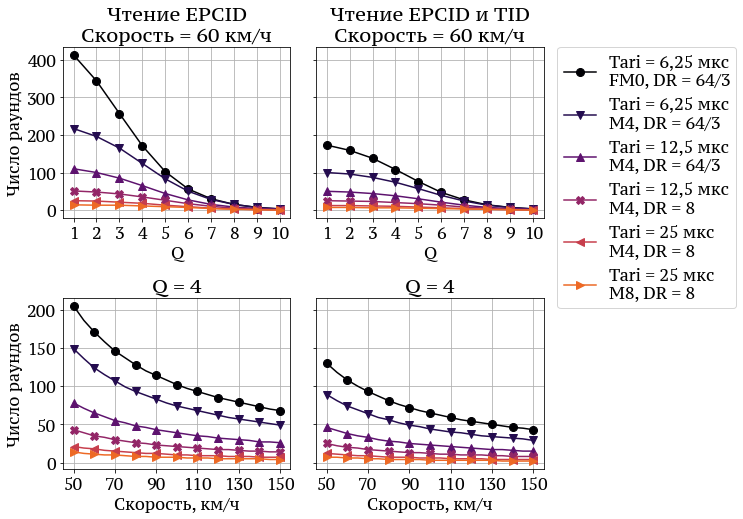

In [127]:
def plot_num_rounds(out: Union[str, Sequence[str]] = ()):
    fig, axes = plt.subplots(figsize=(8, 7.5), nrows=2, ncols=2, sharey='row')
    (ax0, ax1), (ax2, ax3) = axes
    
    ov = np.linspace(50, 150, 21)
    oq = np.arange(1, 11)
    df = DF[DF.TRext == False]
    
    # Определим вспомогательную функцию, которрая вычисляет длительности
    # раундов и изображает их на осях для заданных значений Tari, M, DR
    def plot(inp_index: int, ax_left, ax_right, what_fixed: str):
        tari, m, dr = ROUNDS_TARI_M_DR[inp_index]
        marker = ROUNDS_MARKERS[inp_index]
        color = ROUNDS_COLORS[inp_index]

        df_row = df[(df.Tari == tari) & (df.M == m) & (df.DR == dr)]
        what_fixed = what_fixed.upper()
        
        if what_fixed == "Q":
            ox = ov
            markevery = 2
            oy_epc = [get_num_rounds(df_row, Q, v, use_tid=False) for v in ox]
            oy_tid = [get_num_rounds(df_row, Q, v, use_tid=True) for v in ox]
        elif what_fixed in ["SPEED", "V"]:
            ox = oq
            markevery = 1
            oy_epc = [get_num_rounds(df_row, q, V, use_tid=False) for q in ox]
            oy_tid = [get_num_rounds(df_row, q, V, use_tid=True) for q in ox]
        else:
            raise ValueError("what_fixed should be Q or V")
        
        props = {
            "color": ROUNDS_COLORS[inp_index],
            "marker": ROUNDS_MARKERS[inp_index],
            "markersize": 8,
            "markevery": markevery,
            "label": f"Tari = {tari:n} мкс\n{m.name}, DR = {str_dr(dr)}",
        }
        
        ax_left.plot(ox, oy_epc, **props)
        ax_right.plot(ox, oy_tid, **props)
    
    # ---- конец определения вспомогательной функции -----
    
    for i, _ in enumerate(ROUNDS_TARI_M_DR):    
        plot(i, ax0, ax1, "V")
        plot(i, ax2, ax3, "Q")

    for ax in (ax0, ax1, ax2, ax3):
        ax.grid()
    for ax in (ax0, ax1):
        ax.set_xlabel("Q")
        ax.set_xticks(oq)
    for ax in (ax2, ax3):
        ax.set_xlabel("Скорость, км/ч")
        ax.set_title(f"Q = {Q}")
        ax.set_xticks((50, 70, 90, 110, 130, 150))
    for ax in (ax0, ax2):
        ax.set_ylabel("Число раундов")
    
    ax0.set_title(f"Чтение EPCID\nСкорость = {V} км/ч")
    ax1.set_title(f"Чтение EPCID и TID\nСкорость = {V} км/ч")
    ax2.set_title(f"Q = {Q}")
    
    
    fig.legend(*ax.get_legend_handles_labels(), loc='center right',
               bbox_to_anchor=(1.31, 0.651), ncol=1)

    plt.tight_layout()
    savefig(out)

plot_num_rounds(out=("ch2_max_num_rounds.pdf", "ch2_max_num_rounds.png"))